# CUMMW Workshop (OR 2): Agent-Based Modeling

by Aapeli Vuorinen (<https://aapelivuorinen.com>). IEOR, Columbia University.

## Materials available at: <https://aap.li/cummw>

## Introduction

**Agent-based modeling** is a framework for modeling complex systems that focuses on **agents**, their individual behaviour, and the interactions between agents.

This allows us to study the structure of potentially **very complicated systems** without necessarily needing to be able to compute answers analytically or even write down the full system.

<!--In this workshop, we will look at an agent-based model of virus spread, applied to the wider Columbia University community.-->

<!--The session is loosely related to the session by Prof Ton Dieker on discrete event simulation in that we will compare and discuss the strengths and shortcomings of the two modeling approaches.-->

* the simulation workflow
* "What If" analysis
* the curse of dimensionality
* various tradeoffs such as those between simulation granularity and runtime

## What is agent-based modeling?

Agent-based modeling works by building **simple, autonomous agents** that interact with each other over time. This allows us to build sophisticated models, simulate them, and then study the macro-scale, emergent behavior of large populations of agents. We can then modify the model and perform analyses to study how different rules or agent-level decisions change the outcome of the simulation.

Here's a classical example used to study segregation: <https://ncase.me/polygons/>. You saw a bunch of examples last time in Ton's slides, a lot of the 3D examples were agent-based mdoels. Even computer games can be thought of as agent-based models!

The power of these models is in their simplicity and ease of implementation, as well as the huge variety of different scenarios that can be studied. However, these come with some drawbacks that we'll discuss throughout the workshop, such as their computational complexity meaning we have to make various tradeoffs while modeling.

# A model for COVID-19 at Columbia

## The simulation workflow

An important part of ABM (and any modeling regime) is the actual modeling part. We have to choose the right things to include in the model to make it accurate enough while keeping it computationally tractable. Once a realistic model is built, we can move to **control** by studying how controlling different parameters of the model might influence the outcome. For example, we might try out different rules to limit virus spread, such as reducing the number of students that go to class.

We'll now construct a simple model of COVID-19 and play around with it a bit so you get a feel for how it works.

## The model

To illustrate the point of ABM, we will start with a very basic model. Often when modeling, we first make a simple model and then iterate on it. This is an important part of modeling.

We will model students as the agents that interact with the campus environment, composed of classrooms and apartments. Agents move between classrooms (randomly) and apartments (initial random allocation, but then fixed). Disease spread is random through the population.

### Agents (students)

* There are $N$ students going to campus
* Students live in one of $M$ apartment buildings, each apartment has $B$ bedrooms, and students are allocated randomly into these rooms
* Every weekday (Mon-Fri), students go to one of $K$ (randomly assigned) classes and then back home
* If a student gets infected on a given day, they become infectious at the start of the same day, then remain infectious for a randomly chosen amount of time between 7-10 days

### Interactions between students

* During each day in class, the students have a probability $q$ of getting infected with COVID independently for each student in the same class that is at the time infectious
* During each evening/night, the students have a probability $p$ of getting infected with COVID independently for each infectious housemate

So for example if four students, $A$, $B$, $C$, and $D$ live together in an apartment, with $B$ and $C$ currently infectious, then each evening, student $A$ has probability $p$ of getting infected by $B$, and an independent probability $p$ of getting infected by $C$. Therefore the probability of $A$ getting infected by either $B$ or $C$ (or both) is $p(1-p)+(1-p)p+p^2$. Similarly $D$ has the same probability of being infected each evening.

If a student gets infected during the day, they only become infectious at the start of the next day.

**Questions**:

* Is this a good model?
* What assumptions have we made?
* How should we pick the parameters? (Of course things like $N$ can be chosen from data we have, but what about $p$ and $q$?)

### Imports

In [1]:
# randomization functions
from random import uniform, choice, shuffle

# an enumeration, a set of named things
from enum import Enum

# numpy is a numerical computation library for python
import numpy as np

### Helper function

In [2]:
def bernoulli(prob):
    """
    Returns a random variate that takes value True with probability `prob` and False with probability `1-prob`
    """
    return uniform(0, 1) < prob

### The main `Student` agent

In [3]:
def generate_infectious_time():
    return round(uniform(7,10))

class State(Enum):
    HEALTHY = 1 # also called susceptible
    INFECTIOUS = 2
    IMMUNE = 3 # also called recovered

class StudentAgent:
    def __init__(self):
        # initially we are healthy
        self.state = State.HEALTHY
        # whether the agent has been infected today, and we should mark
        # them as infected when next advancing the disease
        self._infected = False

    def simulate_disease(self, day):
        """
        Simulate the course of disease for this agent
        """
        if self.state == State.HEALTHY:
            if self._infected:
                # we're infected
                self.state = State.INFECTIOUS
                self.infectious_end = day + generate_infectious_time()
            else:
                # do nothing if we're healthy and not infected
                pass
        elif self.state == State.INFECTIOUS:
            if day == self.infectious_end:
                # it's the day we stop being infectious and become immune
                self.state = State.IMMUNE
            else:
                # we're infectious but no need to change state
                pass

    def infect(self):
        self._infected = True

    def infectious(self):
        """
        Whether we're currently infectious or not
        """
        return self.state == State.INFECTIOUS

    def have_been_sick(self):
        """
        If this agent has ever been sick or not
        """
        return self.state != State.HEALTHY

### Some helper classes and functions

In [4]:
class Apartment:
    """
    This is just a placeholder for some info with a few convenience functions. It could easily be replaced by a list.
    """
    def __init__(self, capacity):
        self.occupants = []
        self.capacity = capacity

    def add_occupant(self, occupant):
        self.occupants.append(occupant)

    def is_full(self):
        return len(self.occupants) == self.capacity

class Days(Enum):
    MONDAY = 1
    TUESDAY = 2
    WEDNESDAY = 3
    THURSDAY = 4
    FRIDAY = 5
    SATURDAY = 6
    SUNDAY = 7

def randomly_infect(group, prob):
    """
    Given a group of students, randomly infects each pair of students with probability prob
    """
    # for each pair of occupants, they get infected with prob p
    for agent1 in group:
        for agent2 in group:
            # we simulate a possible infection event for each pair where one is infected and the other is not
            if agent1.infectious() and not agent2.infectious():
                if bernoulli(prob):
                    agent2.infect()

def assign_to_classrooms(students, number_of_classrooms):
    """
    Reandomly assign students into classrooms with roughly the same number of students in each.
    
    This is a confusing function, don't worry if you don't understand how it works.
    
    Returns a list of lists.
    """
    # randomize the order of students
    shuffle(students)
    # divide into equal chunks
    return [students[i::K] for i in range(number_of_classrooms)]

### The main simulation loop

In [5]:
def run_simulation(N, M, B, K, p, q):
    # create the students and apartments
    students = [StudentAgent() for _ in range(N)]
    apartments = [Apartment(capacity=B) for _ in range(M)]

    # infect ten student at the start
    for i in range(10):
        students[i].infect()
    
    # randomize the students (so those 10 end up in random spots)
    shuffle(students)
    
    # randomly allocate students into apartments
    for student in students:
        apartments_with_space = [apartment for apartment in apartments if not apartment.is_full()]
        
        # choose a random apartment
        random_apartment = choice(apartments_with_space)
        random_apartment.add_occupant(student)
    
    infected_count = []
    sick_count = []
    
    day_number = 0

    # let's run for 12 weeks
    for week in range(12):
        # and then for each day in the week, we simulate
        for day in Days:
            # on weekday mornings, we go to class
            if day not in [Days.SATURDAY, Days.SUNDAY]:
                # randomly assign to classrooms
                classrooms = assign_to_classrooms(students, K)
    
                # within classrooms agents may infect each other
                for classroom in classrooms:
                    randomly_infect(classroom, q)

            for apartment in apartments:
                randomly_infect(apartment.occupants, p)

            infected_count.append(np.sum([student.infectious() for student in students]))
            sick_count.append(np.sum([student.have_been_sick() for student in students]))
            
            day_number += 1

            # advance the state of the simulation for each agent
            for agent in students:
                agent.simulate_disease(day_number)
            
    infected_count_daily_change = np.diff(infected_count)
    sick_count_daily_change = np.diff(sick_count)
    
    # total number of agents who ever got sick
    total_sick = sick_count[-1]

    return total_sick, infected_count, infected_count_daily_change, sick_count, sick_count_daily_change

### More helpers (you can ignore these)

In [6]:
# creates a context manager to time an operation
import time
from contextlib import contextmanager
import matplotlib.pyplot as plt

@contextmanager
def timer():
    start = time.perf_counter_ns()
    yield
    print(f"Took {(time.perf_counter_ns() - start) / 1e9} sec.")

# plots two side-by-side plots
def plot_infected_and_change(infected_count, daily_change, title1, title2):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

    ax1.plot(infected_count)
    ax1.set_xlabel("Day of simulation")
    ax1.set_title(title1)
    ax1.set_xticks(np.arange(0, len(infected_count) + 1, 7))

    ax2.plot(daily_change)
    ax2.set_xlabel("Day of simulation")
    ax2.set_title(title2)
    ax2.set_xticks(np.arange(0, len(infected_count) + 1, 7))

    plt.show()

### Define some model parameters

In [7]:
# number of students
N = 1000

# number of apartments
M = 500

# capacity of each apartment
B = 3

# number of classrooms
K = 100

# daily probability of getting covid for each infected person when at home
p = 0.04

# daily probability of getting covid for each infected person when in classroom
q = 0.02

Took 0.507540077 sec.


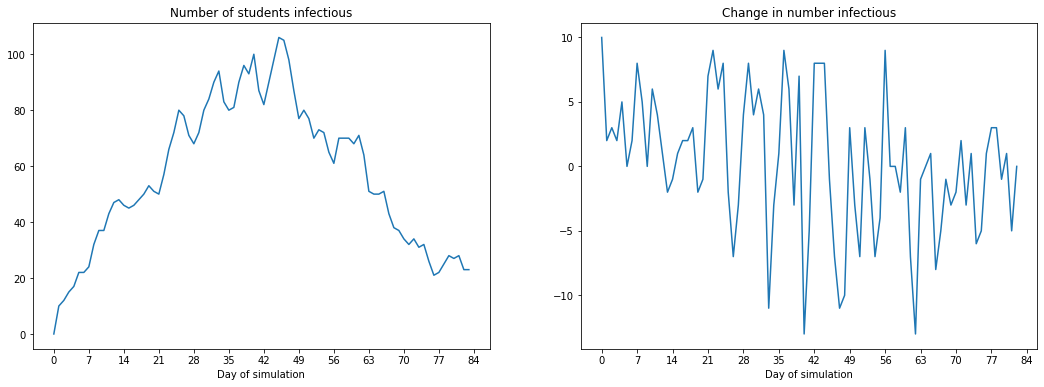

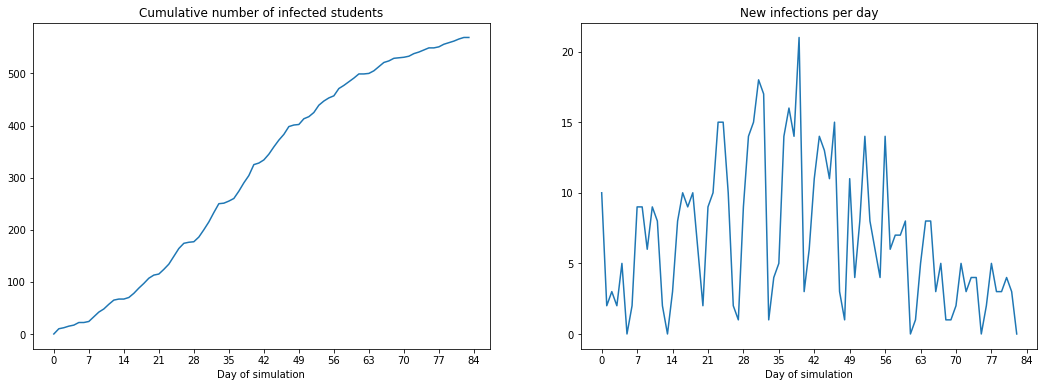

In [8]:
with timer():
    total_sick, infected_count, infected_count_daily_change, sick_count, sick_count_daily_change = run_simulation(N, M, B, K, p, q)
plot_infected_and_change(infected_count, infected_count_daily_change, "Number of students infectious", "Change in number infectious")
plot_infected_and_change(sick_count, sick_count_daily_change, "Cumulative number of infected students", "New infections per day")

We can see that if there is no intervention, even ten students will cause a full outbreak. You can also see the effect of weekends here with the "steps" in the graph.

Note that this simulation took around half a second to run (on my computer), compared to the much faster DESs. There is an important tradeoff here with model complexity and 

**Questions**:

* Why do only ~600 students ever get infected before the pandemic dies? Why not all 1000?
* What happens if we run this again, do we get the same result?
* Do our assumptions hold?
* Was our model reasonable? What could we tweak?

This model is a bit unrealistic (for many reasons) and does not model the real world perfectly.

One of the main ones is that infeciton is a boolean attribute (everyone is either infected or healthy), and once infected, they don't stop being infected (and infectious). For a more realistic model, we need 

## What if we mandated people to use masks in class?

Suppose we set up a rule where people had to use masks in class. This might lead to the probability of infection in class reducing by, say 20%. We can now test out what happens in this scenario:

Took 0.463667652 sec.


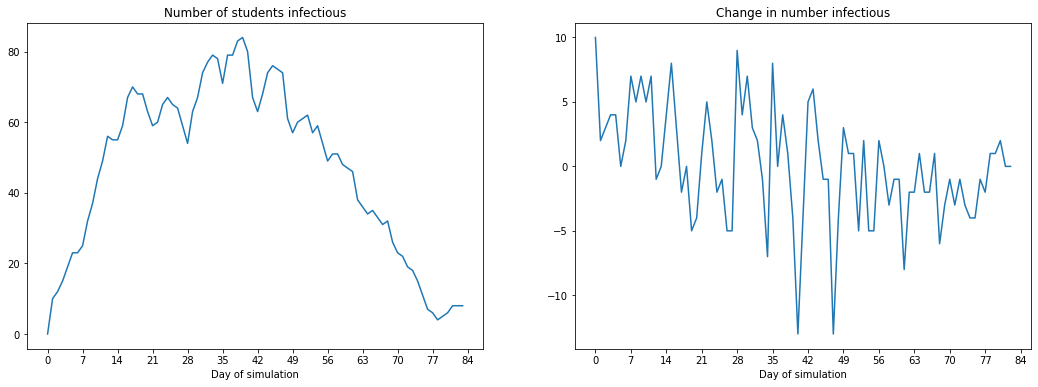

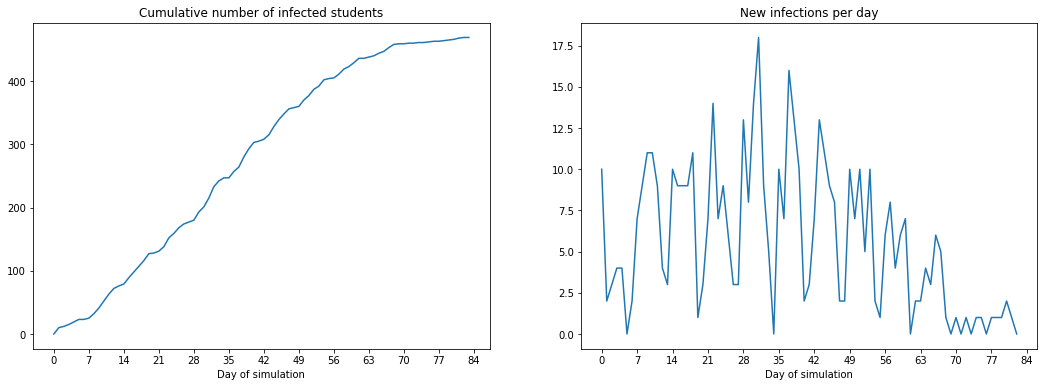

In [9]:
new_q = 0.8 * q

with timer():
    total_sick, infected_count, infected_count_daily_change, sick_count, sick_count_daily_change = run_simulation(N, M, B, K, p, new_q)
plot_infected_and_change(infected_count, infected_count_daily_change, "Number of students infectious", "Change in number infectious")
plot_infected_and_change(sick_count, sick_count_daily_change, "Cumulative number of infected students", "New infections per day")

# Hands on: play around with the model and see what happens

Study how the current model reacts to changing the input parameters, or choose some tweak to implement to the model and see how the system behaves given that change. Come up with your own or pick one from the list below.

## (Easy): Study the variability in the simulation output

Run the simulation multiple times (for example with a for loop), and look at how the simulation output changes. Why does the number of people who ever got sick vary so much?

## (Easy): Study how the total number of people who got sick changes with the parameters

Write a `for` loop to run the simulation mutiple times Plot a graph of the total number of people who got sick at any time as a function of $p$.

## (Medium): Implement a "hybrid" mode of teaching

Set aside a proportion of students, say 20%, and make them not go to class (pretend they attend online and stay home during the day). Does that make a difference.

## (Medium): Allocate students to apartments in a better way

What if we allocate students to apartments in order to minimize the number of students per apartment, instead of randomly? Does this change the outcome?

## (Medium): Allocate students to classes more realistically

Currently, students wake up in the morning and get assigned to a new classroom randomly. Make some kind of schedule for each student, and see how it influences the simulation. For example, what if each student just went to the same class each day?

## (Hard): Implement social gatherings

Implement some kind of logic for students to go out in the evenings and socialize. How does this extra mixing of students change the simulation output?

## (Hard): Implement an incubation period

When people really get infected with COVID-19, they don't get symptoms immediately, there is a period of time, up to a week when they do not exhibit symptoms. Implement an extra state for agents and see how this influences the simulation output.

## (Really hard): Implement testing and quarantine

Starting from the above, see if you can implement a testing regime where student are randomly sampled and if they are found to be in incubating state, they are put into quarantine where they won't go to class.

# Python list comprehensions

Hopefully by now you've seen a bit of Python here and there. It's an extremely expressive and powerful language, and mostly you can figure out what's going on by just reading it. There's however a few small piece of syntax I'll highlight to help you see what's going on.

### List comprehensions

List comprehensions are a shortcut for loops where you want to perform some operation for everything in a list and store their return values in a list. I've used them a fair bit here to simplify code.

```py
apartments_with_space = [apartment for apartment in apartments if not apartment.is_full()]

# is equivalent to this:
apartments_with_space = []

for apartment in apartments:
    if not apartment.is_full():
        apartments_with_space.append(apartment)
```

I also use the underscore (`_`) to denote a variable I don't care about. In a list comprehension, you have to assign the list values to something. So:

```py
students = [StudentAgent() for _ in range(N)]

# is equivalent to
students = []

for _ in range(N):
    students.append(StudentAgent())
```

You can read more at <https://docs.python.org/3/tutorial/datastructures.html#list-comprehensions>.